In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
import albumentations as A
from albumentations import OneOf
import numpy as np
from transformers import BeitConfig

from transformers import BeitFeatureExtractor, BeitForMaskedImageModeling
from PIL import Image
import requests
import cv2
from random import randint
import torch.nn.functional as F
import pdb

In [3]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

### +Take image

In [4]:
url = 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-0.jpg'
image = Image.open(requests.get(url, stream=True).raw)

### +Masking patches (16,16) randomly in Image (224,224)

In [5]:
input_image = cv2.resize(np.array(image), (224, 224))
num_hole=74
size_hole=16
for indx in range(num_hole):
    value_x=randint(0,int(224/16))
    value_y=randint(0,int(224/16))
    input_image[size_hole*value_y:size_hole*(value_y+1), size_hole*value_x:size_hole*(value_x+1),:] = 169

### +Visualize input Image

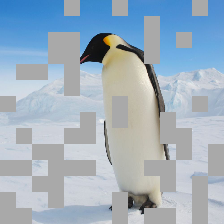

In [6]:
Image.fromarray(input_image)

### +Config extractor for Beit Encoder

In [7]:
config_Extractor=BeitFeatureExtractor(do_resize=True,\
                                      size=224, resample=3,\
                                      do_center_crop=True,\
                                      crop_size=224,\
                                      do_normalize=True,\
                                      image_mean=None,\
                                      image_std=None)
extractor = config_Extractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k')

### +Config Beit Encoder

In [8]:
config_Encoder = BeitConfig()
Encoder = BeitForMaskedImageModeling(config_Encoder).from_pretrained('microsoft/beit-base-patch16-224-pt22k')
Encoder = Encoder.cuda()

### +Config Decoder

In [9]:
dev = torch.device('cuda:0')
Decoder = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

## +Forward model

In [10]:
inputs = extractor(images=input_image, return_tensors="pt")['pixel_values']
inputs = inputs.cuda()
out_encoder = Encoder(inputs)
logits = out_encoder.logits
logits=logits.view(1, 14, 14, 8192)
logits = logits.permute(0,3,1,2)
logits = torch.argmax(logits, axis=1)
logits = F.one_hot(logits, num_classes=8192).permute(0, 3, 1, 2).float()
output = Decoder(logits).float()
output = unmap_pixels(torch.sigmoid(output[:, :3]))
img_out = T.ToPILImage(mode='RGB')(output[0].cpu())

# +Compare Input Image and Output Image

### + Input Image

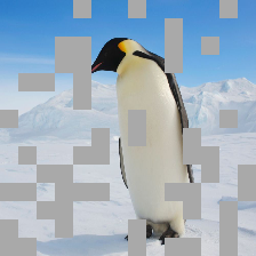

In [11]:
Image.fromarray(input_image).resize((256,256))

### + Output Image

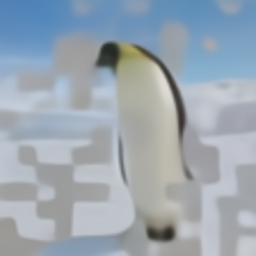

In [12]:
img_out.resize((256,256))